In [2]:
from pandas_datareader import data
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns

ModuleNotFoundError: No module named 'tensorflow.keras'

In [ ]:
start_date = dt.datetime.now() - dt.timedelta(days=365 * 50)
end_date = dt.datetime.now()

df = yf.download("AMAT", start=start_date, end=end_date)

print("hi")

df.reset_index(inplace=True)

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['50_day_ma'] = df['Close'].rolling(window=50).mean()
df['1000_day_ma'] = df['Close'].rolling(window=1000).mean()
df['10_day_vol_avg'] = df['Volume'].rolling(window=10).mean()
df['200_day_vol_avg'] = df['Volume'].rolling(window=200).mean()

df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']]

df.to_csv('AMAToutput.csv', index=False)

print(df)

NameError: name 'dt' is not defined

In [57]:
dfm = df.loc[1000:,:]
dfm = dfm.sample(100)

In [58]:
#corr = dfm.corr()
#corr.style.background_gradient(cmap='coolwarm').format(precision=2)

c:\Users\hello\anaconda3\envs\tfdml_plugin\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


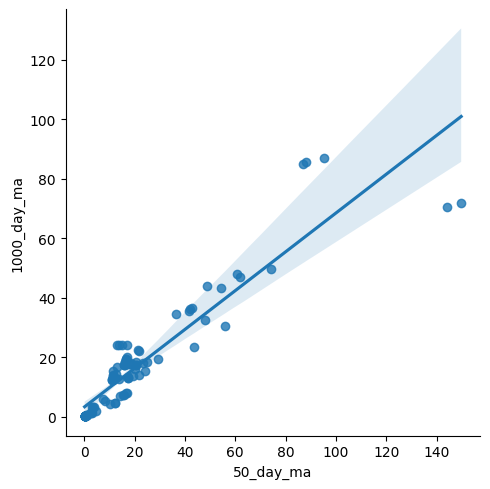

In [59]:
sns.lmplot(data=dfm, x='50_day_ma', y='1000_day_ma')

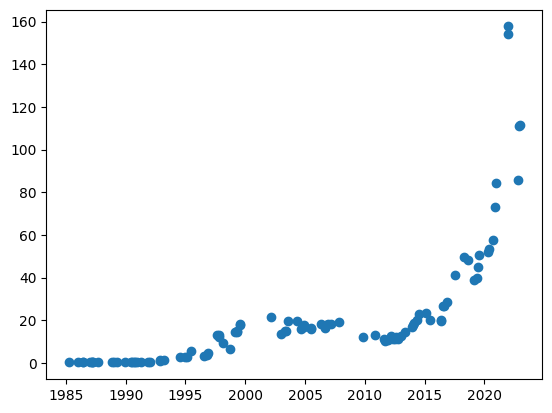

In [60]:
plt.plot_date(dfm['Date'], dfm['Open'])

In [61]:
df.set_index('Date', inplace=True)

df.dropna(inplace=True)

df = df.drop(df.index[0:2000])

train_df = df.sort_values(by=['Date']).copy()

#FEATURES = ['Close', '50_day_ma', '200_day_ma']
FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']

print('FEATURE LIST')
print([f for f in FEATURES])

print(df)

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']
                  Open        High         Low       Close    Volume  \
Date                                                                   
1992-01-27    0.593750    0.597656    0.582031    0.589844   6912000   
1992-01-28    0.597656    0.605469    0.593750    0.597656  10969600   
1992-01-29    0.593750    0.628906    0.593750    0.609375  17113600   
1992-01-30    0.609375    0.625000    0.582031    0.597656  16531200   
1992-01-31    0.597656    0.607422    0.593750    0.599609   4000000   
...                ...         ...         ...         ...       ...   
2023-07-31  151.929993  152.679993  150.520004  151.589996   4184400   
2023-08-01  150.919998  152.860001  150.279999  152.630005   3088100   
2023-08-02  150.619995  150.619995  146.880005  147.330002   5468300   
2023-08-03  146.009995  148.699997  145.360001  147.809998   4338600   
2023-08-04  147

C:\Users\hello\AppData\Local\Temp\ipykernel_24140\2984631803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [62]:
sequence_length = 200

index_Close = data_filtered.columns.get_loc("Close")

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.9)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

In [63]:
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    print(index_Close)
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i, index_Close])

    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

3
3
(6946, 200, 9) (6946,)
(794, 200, 9) (794,)
0.0030037077102985765
0.0030037077102985765


InvalidArgumentError: Multiple OpKernel registrations match NodeDef at the same priority '{{node AssignVariableOp}}': 'op: "AssignVariableOp" device_type: "GPU" constraint { name: "dtype" allowed_values { list { type: DT_INT64 } } } host_memory_arg: "resource"' and 'op: "AssignVariableOp" device_type: "GPU" constraint { name: "dtype" allowed_values { list { type: DT_INT64 } } } host_memory_arg: "resource"'
	 [[AssignVariableOp]] [Op:AssignVariableOp]

In [ ]:
model.compile(optimizer='adam', loss='mse')

epochs = 30
batch_size = 32
early_stop = EarlyStopping(monitor='loss', patience = 3, verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/30
 50/218 [=====>........................] - ETA: 56:20 - loss: 0.0771

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

In [ ]:
display_start_date = "2023-01-01"

train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

print(df_union.index)

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("AMAT", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

X_test_new = []
X_test_new.append(last_N_days_scaled)

pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''

print(f'The close price for {"AMAT"} at {str(dt.date.today())} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')


In [ ]:
df_temp = df[-sequence_length-250:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

predicted_prices = []
ground_truth_prices = []
naive_prices = []
percentage_diff = []
percentage_naive = []

for i in range(49, 0, -1):
  last_N_days = new_df[-sequence_length-i:-i].values
  last_N_days_scaled = scaler.transform(last_N_days)

  X_test_new = []
  X_test_new.append(last_N_days_scaled)

  pred_price_scaled = model.predict(np.array(X_test_new))
  pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

  price_today = np.round(new_df['Close'][-i-1], 2)
  price_naive = np.round(new_df['Close'][-i-2], 2)
  predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
  change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)
  change_percent_naive = np.round(100 - (price_today * 100)/price_naive, 2)

  predicted_prices.append(predicted_price)
  ground_truth_prices.append(price_today)
  naive_prices.append(price_naive)
  percentage_diff.append(change_percent)
  percentage_naive.append(change_percent_naive)

new_df.reset_index(inplace=True)

plt.figure(figsize = (18,9))
plt.plot(predicted_prices)
plt.plot(ground_truth_prices)
plt.plot(naive_prices)
plt.xticks(range(0,new_df.shape[0],500),new_df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)
plt.title('Closing Price of AMAT',fontsize=22)
plt.show()


In [ ]:
import statistics

# Step 1: Convert the percentages to decimals
decimals_diff = [percentage / 100 for percentage in percentage_diff]
decimals_naive = [percentage / 100 for percentage in percentage_naive]

# Step 2: Calculate the standard deviation
standard_deviation_model = statistics.stdev(decimals_diff)
standard_deviation_naive = statistics.stdev(decimals_naive)

# Print the result
print("Standard Deviation Model:", standard_deviation_model)
print("Standard Deviation Naive:", standard_deviation_naive)


In [ ]:
#Graph the closing price of AMAT

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),df['Close'])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)
plt.title('Closing Price of AMAT',fontsize=22)
plt.show()